# Probabilistically Weighted Adaptive Random Forest Drift Detection Ensemble Classification Framework (PWARFDDE)

## The Problem of Batch Learning for NIDS
Concept drift means that the statistical properties of the target variable, which the model is trying to predict, change over time in unforeseen ways. This causes problems because the predictions become less accurate as time passes.

This is a pressing issue in the sphere of Intrusion Detection Systems and is obvious when examining our offline machine learning models. 

In traditional batch learning approaches, data is accumulated over a period of time. The machine learning model is then trained with this accumulated data from time to time in batches. It is the direct opposite of online learning because the model is unable to learn incrementally from a stream of live data. In batch learning, the machine learning algorithm updates its parameters only after consuming batches of new data.
‍
The fact that models are trained with large batches of accumulated data means that more time and resources such as CPU, memory space, and disk input/output are needed. It also takes longer to push models to production because this can only be done at certain intervals based on the performance of the model after being trained with new data.
‍
If a model that has been trained using batch learning needs to learn about new data, it must be retrained using the new dataset. 

While it is often a robust approach, when the data is changing constantly and quickly, this approach fails to adapt to the new properties of the data at a rate that leads to satisfactory models. As such on the NSL-KDD dataset, as the dataset was pre-split. Meaning we didnt have to train test split, there were underlying properties to the test set that we had no exposure too. As such it was impossible for our models to learn these nuisances and thus the accuracy for both Deep Learning and Classical approaches struggled to break the 80% accuracy barrier. 

While the 80% accuracy, in theory isnt too unacceptable, the problem lies in the Type I and Type II error distributions for these approaches. All the batch learning approaches suffered from a high rate of Type II. In the case of NIDS (Network intrusion Detection Systems), Type I error (false positive). A false positive state is when the NIDS identifies an activity as an attack but the activity is acceptable behavior. A false positive is a false alarm. Type II (false negative) is the most serious and dangerous state. This is when the IDS identifies an activity as acceptable when the activity is actually an attack. That is, a false negative is when the IDS fails to catch an attack. This is the most dangerous state since the security professional has no idea that an attack took place. False positives, on the other hand, are an inconvenience at best and can cause significant issues. However, with the right amount of overhead, false positives can be successfully adjudicated; false negatives cannot.

Thus it is absolute vital that we reduce Type II error as much as possible.

## Setup 

In [ ]:
pip install river

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 4.8 MB/s 


In [ ]:
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler, StandardScaler

import tensorflow as tf

import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.decomposition import PCA
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier
from river.drift import DDM, ADWIN,EDDM,HDDM_A,HDDM_W,KSWIN,PageHinkley
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RepeatedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn import metrics

pd.set_option('display.max_columns',None)
warnings.filterwarnings('ignore')
from sklearn.metrics import roc_curve,accuracy_score,f1_score,auc,confusion_matrix,roc_auc_score,plot_confusion_matrix
%matplotlib inline 
from river import metrics
from river import stream
from river import tree,neighbors,naive_bayes,ensemble,linear_model
from river.drift import DDM, ADWIN
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score, precision_score, recall_score, f1_score
import lightgbm as lgb
import time

In [ ]:
def quick_report(y_test_qr, y_pred_qr):
    print("Accuracy: "+ str(accuracy_score(y_test_qr, y_pred_qr)))
    print(classification_report(y_test_qr, y_pred_qr))

In [ ]:
# unzip our pre processed data (ie x_train, y_train ... etc.)
# Works for Google Collab, have not tried for jupyter notebook (will probably need specific path)
!unzip /content/Processed_Data.zip

Archive:  /content/Processed_Data.zip
   creating: Processed_Data/
  inflating: Processed_Data/x_train.csv  
  inflating: __MACOSX/Processed_Data/._x_train.csv  
  inflating: Processed_Data/y_train.csv  
  inflating: __MACOSX/Processed_Data/._y_train.csv  
  inflating: Processed_Data/y_test.csv  
  inflating: __MACOSX/Processed_Data/._y_test.csv  
  inflating: Processed_Data/x_test.csv  
  inflating: __MACOSX/Processed_Data/._x_test.csv  


In [ ]:
from numpy import loadtxt
def load_preprocessed_data(path):
  x_train = loadtxt("{}/x_train.csv".format(path), delimiter=',')
  y_train = loadtxt("{}/y_train.csv".format(path), delimiter=',')
  x_test  = loadtxt("{}/x_test.csv".format(path), delimiter=',')
  y_test  = loadtxt("{}/y_test.csv".format(path), delimiter=',')
  return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = load_preprocessed_data('/content/Processed_Data')
# reduced data size for faster training / predictions for testing 
x_train_reduced = x_train[0:1000,:]
y_train_reduced = y_train[0:1000]
x_test_reduced = x_test[0:1000,:]
y_test_reduced = y_test[0:1000]

## Proposed Approach based on Research

### Model based on the work done in the following Papers
[Adaptive random forests for evolving data stream classification](https://link.springer.com/article/10.1007/s10994-017-5642-8)

[A Machine Learning Approach to Brain Tumors Segmentation Using Adaptive Random Forest Algorithm](https://ieeexplore.ieee.org/abstract/document/8735072?casa_token=335DFkHuV0YAAAAA:HzRCbruNEcLQ0d6VYlV_BrZJTKW-DHv8ofBmlmilPHDAFddsH9nRSvrdh6lUrO0gAF-Ga8LX6A)

[Anomalies Detection Using Isolation in Concept-Drifting Data Streams](https://www.mdpi.com/2073-431X/10/1/13)

[Stream-based Machine Learning for Network Security and Anomaly Detection](https://dl.acm.org/doi/abs/10.1145/3229607.3229612)

[Ensemble Methods in Machine Learning](https://link.springer.com/chapter/10.1007/3-540-45014-9_1)

[Weighted ensemble of statistical models](https://www.sciencedirect.com/science/article/pii/S0169207019301190?casa_token=nR4Gh0sXnYoAAAAA:YVVVCGeJ-FWdVivJQDTilmw8K5Mg4zxKA-RhvZaEwlesszRVmowQcBaooOiU8Cd-6NQv1kvf)

[Fast Unsupervised Online Drift Detection Using Incremental Kolmogorov-Smirnov Test](https://dl.acm.org/doi/abs/10.1145/2939672.2939836?casa_token=okL37GZo3OUAAAAA:YszvO8XEMu_0QSatSzOzQDWLclvi_fTEF2_V4sCAJabCvD4W6sTyFmMRDJkUPkrGDPwx7UbGp7_V)

[Comparative Evaluation of the Supervised Machine Learning Classification Methods and the Concept Drift Detection Methods in the Financial Business Problems](https://link.springer.com/chapter/10.1007/978-3-030-75418-1_13)

[Lightweight adaptive Random-Forest for IoT rule generation and execution](https://www.sciencedirect.com/science/article/pii/S2214212616302332?casa_token=Ldhh0AONnocAAAAA:X7gJlkJn1jFLn97Wzhr8533w7UkzsmMOML0M8Ojx1mZ0Q1YDC8Du4WcC8HmRoq3dfivL7jaa)

[A Multi-Stage Automated Online Network Data Stream Analytics Framework for IIoT Systems](https://arxiv.org/abs/2210.01985)

[Learning with Drift Detection](https://link.springer.com/chapter/10.1007/978-3-540-28645-5_29)

[Online Ensemble Using Adaptive Windowing for Data Streams with Concept Drift](https://journals.sagepub.com/doi/full/10.1155/2016/4218973)

[Early Drift Detection Method](https://d1wqtxts1xzle7.cloudfront.net/48905428/Early_Drift_Detection_Method_20160917-1085-1m513qn-with-cover-page-v2.pdf?Expires=1665862560&Signature=aEtMrhX7j8SI~-akhnqouNvDeT1cLfY72heLVbA21MXITtkVf0DWG0oNtIiMANQLlQtVbd5s~a0tna~mA1TCPmm8VHA5yg3XPJp4mxRTlug3LzJ-BcHhlnGZbqgHiabRvbDMIuaElDC9dEHFOISvWHC2rzzh3gibvQdKFLH72wg5bZ2qKY1icOw3fIrP~Mp4e8ArPP21VIuUyL3ksYkDDmn14LMG95vT-nRlA85-E6Rp4NsNWdjGPh3h12X9oSRxsQ-~2leOLnt~4TCfUUIMVK4KbEDGys5xrMddjHooOEjRJSeEwb3xzqybPh0vbnwQXNhfIWw~ybxcva6RGDpbMQ__&Key-Pair-Id=APKAJLOHF5GGSLRBV4ZA)

[Streaming Random Patches for Evolving Data Stream Classification](https://ieeexplore.ieee.org/document/8970784)

[PWPAE: An Ensemble Framework for Concept Drift Adaptation in IoT Data Streams](https://ieeexplore.ieee.org/document/9685338)

[Learning from Time-Changing Data with Adaptive Windowing](https://epubs.siam.org/doi/abs/10.1137/1.9781611972771.42)

[Self-Adaptive Windowing Approach for Handling Complex Concept Drift](https://link.springer.com/article/10.1007/s12559-015-9341-0)

[A Lightweight Concept Drift Detection and Adaptation Framework for IoT Data Streams](https://ieeexplore.ieee.org/document/9427288)

### Proposed Structure
- Various Ensemble Adaptive Random Forest Classifiers are trained, each stacked with a different drift detection algorithm. 
- These models are trained using a data stream / online machine learning approach. (data is passed point by point)
- Once the models are trained they are then used to predict the test data. 
- The test data is also streamed. 
-  Several variables need to be tracked for each pass, they include; <br>
    - Accuracy of ensemble model (stacked)
    - Accuracy of each individual ensemble method
    - Error rate for each model and overall model (used for weighting)
    - The predicted class and probability from each model 
- For each pass the following will occur; <br>
    1. Each of the models will predict the ith target 
    2. The prediction is compared vs the true value and the accuracy for each model is updating accordingly 
    3. We calculate a new error rate based on the accuracy of the model (1 - accuracy)
    4. We calculate the accumalative error rate
    5. We calculate the weighting for each model ((1 - model error) / total error) 
    6. For each model we get the probability of the ith target belonging to each class (we are assuming binary classification) 
    7. The total probability is calculated for each class using weight * model probability
    8. The ensemble model will classify the target simply based on the larger probabilty
    9. Update the ensemble accuracy 
    10. Repeat until we have worked through entire data stream

#### Misc / Extra 
- Tracking various variables so we can visualise the training and accuracy (e.g. So we can utilize our custom classification Report Functions)
- Build in a data pre processing pipeline to the overall model structure. 
    - By doing this it will allow the ability to simply feedback a raw data set and specify the target and the model will do the rest. 
    - Will need imputation methods for both categorical and numeric
    - Will need encoding for categorical 
    - Will need scaling for numeric 
    - Additional features such as feature selection and dimension reduction techniques could be considered.
    - Given the nature of the problem, will need to consider imbalanced data sets and techniques to combat this such as Over/under sampling/ SMOTE etc.
    - Potential to expand to multi class problems?? - Will need to rework weighting and ensemble classification approach but definitely doable

### Model

#### Analysis Functions

In [ ]:
# Define a figure function that shows the real-time accuracy changes
def accuracy_plot(samples, real_time_accuracy, model_name, dataset_name):
    plt.rcParams.update({'font.size': 15})
    plt.figure(1,figsize=(10,6)) 
    sns.set_style("whitegrid")
    plt.clf() 
    plt.plot(samples,real_time_accuracy,'-r',label='Avg Accuracy: %.2f%%'%(real_time_accuracy[-1]))
    plt.legend(loc='best')
    plt.title(model_name+' on ' + dataset_name, fontsize=15)
    plt.xlabel('Number of samples')
    plt.ylabel('Accuracy (%)')
    plt.draw()

In [ ]:
pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import scikitplot as skplt
def classification_custom_report(model,y_test_cp,y_pred_cp,x_test_cp,model_type,con_mat=True,class_report= True,metrics = True,
                                 roc = True, time_ = True):
    print('--------------- MODEL ACCURACY ---------------')
    print('\n')

    print("Accuracy: "+ str(accuracy_score(y_test_cp, y_pred_cp)))

    cm = confusion_matrix(y_test_cp, y_pred_cp)
    if con_mat==True:
        print('--------------- CONFUSION MATRIX ---------------')
        print('\n')
        cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                     index=['Predict Positive:1', 'Predict Negative:0'])

        sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
        plt.show()

        print('\nTrue Positives(TP) = ', cm[0,0])

        print('\nTrue Negatives(TN) = ', cm[1,1])

        print('\nFalse Positives(FP) (Type I Error) = ', cm[0,1])

        print('\nFalse Negatives(FN) (Type II Error) = ', cm[1,0])
        
    if class_report==True:

        print('\n')
        print('--------------- CLASSIFICATION REPORT ---------------')
        print('\n')

        print(classification_report(y_test_cp, y_pred_cp))
    
    if metrics==True:
        
        print('\n')
        print('--------------- PERFORMANCE METRICS ---------------')
        print('\n')

        TP = cm[0,0]
        TN = cm[1,1]
        FP = cm[0,1]
        FN = cm[1,0]

        classification_accuracy = (TP + TN) / float(TP + TN + FP + FN)
        print('Classification accuracy : {0:0.4f}'.format(classification_accuracy))

        # print classification error

        classification_error = (FP + FN) / float(TP + TN + FP + FN)

        print('Classification error : {0:0.4f}'.format(classification_error))

        # print precision score

        precision = TP / float(TP + FP)


        print('Precision : {0:0.4f}'.format(precision))

        recall = TP / float(TP + FN)

        print('Recall or Sensitivity : {0:0.4f}'.format(recall))

        false_positive_rate = FP / float(FP + TN)
        print('False Positive Rate : {0:0.4f}'.format(false_positive_rate))
        specificity = TN / (TN + FP)
        print('Specificity : {0:0.4f}'.format(specificity))
    
    if roc ==True:
        if model_type=="Classical":
            print('\n')
            print('----------------- ROC - AUC Curve -----------------')
            print('\n')

            y_true = y_test # ground truth label
            y_probas = model.predict_proba(x_test_cp) # predicted probabilities generated by sklearn classifier
            plt.figure(1,figsize=(8,5)) 
            skplt.metrics.plot_roc(y_true, y_probas, figsize=(16,8), title_fontsize=25, text_fontsize=16, cmap='plasma')
            plt.grid(False)
            plt.show()
            score = roc_auc_score(y_test,model.predict(x_test_cp))
            print("Overall AUC: {:.3f}" .format(score))
        elif model_type=="Deep":

        
            print('\n')
            print('----------------- ROC - AUC Curve -----------------')
            print('\n')
            y_pred_keras = model.predict(x_test_cp).ravel()
            fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test_cp, y_pred_cp)
            fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test_cp, y_pred_cp)
            auc_rf = auc(fpr_rf, tpr_rf)
            auc_keras = auc(fpr_keras, tpr_keras)


            plt.figure(1,figsize=(8,5)) 
            plt.plot([0, 1], [0, 1], 'k--')
            plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
            plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
            plt.xlabel('False positive rate')
            plt.ylabel('True positive rate')
            plt.title('ROC curve')
            plt.legend(loc='best')
            plt.show()
        

        

    if time_ == True:
    
        print('\n')
        print('----------------- Accuracy Over Time Graph -----------------')
        print('\n')
        acc = []
        acc_sum = 0
        for i in range(0, len(y_test_cp)):
            if y_test_cp[i] == y_pred_cp[i]:
                acc_sum = acc_sum + 1  
            accuracy = acc_sum/(i+1)
            acc.append(accuracy)

            # Plot the accuracy changes
        plt.rcParams.update({'font.size': 20})
        plt.figure(1,figsize=(8,5)) 
        plt.clf() 
        plt.plot(acc,'-b',label='Accuracy')



        plt.legend(loc='best')
        plt.title('Accuracy Change', fontsize=20)
        plt.xlabel('Timestamp')
        plt.ylabel('Accuracy')

        plt.draw()

    
    
    
# Example of function call
# classification_custom_report(rrf,y_test,y_pred,x_test)

In [ ]:
import scikitplot as skplt
from river import metrics
def classification_custom_report_ensemble(y_test_cp,y_pred_cp,x_test_cp, data_indices, real_time_acc):
    print('--------------- MODEL ACCURACY ---------------')
    print('\n')

    print("Accuracy: "+ str(accuracy_score(y_test_cp, y_pred_cp)))

    cm = confusion_matrix(y_test_cp, y_pred_cp)
  
    print('--------------- CONFUSION MATRIX ---------------')
    print('\n')
    cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                  index=['Predict Positive:1', 'Predict Negative:0'])

    sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
    plt.show()

    print('\nTrue Positives(TP) = ', cm[0,0])

    print('\nTrue Negatives(TN) = ', cm[1,1])

    print('\nFalse Positives(FP) (Type I Error) = ', cm[0,1])

    print('\nFalse Negatives(FN) (Type II Error) = ', cm[1,0])
    


    print('\n')
    print('--------------- CLASSIFICATION REPORT ---------------')
    print('\n')

    print(classification_report(y_test_cp, y_pred_cp))


    
    print('\n')
    print('--------------- PERFORMANCE METRICS ---------------')
    print('\n')

    TP = cm[0,0]
    TN = cm[1,1]
    FP = cm[0,1]
    FN = cm[1,0]

    classification_accuracy = (TP + TN) / float(TP + TN + FP + FN)
    print('Classification accuracy : {0:0.4f}'.format(classification_accuracy))

    # print classification error

    classification_error = (FP + FN) / float(TP + TN + FP + FN)

    print('Classification error : {0:0.4f}'.format(classification_error))

    # print precision score

    precision = TP / float(TP + FP)


    print('Precision : {0:0.4f}'.format(precision))

    recall = TP / float(TP + FN)

    print('Recall or Sensitivity : {0:0.4f}'.format(recall))

    false_positive_rate = FP / float(FP + TN)
    print('False Positive Rate (Type I Error): {0:0.4f}'.format(false_positive_rate)) 
    false_negative_rate = FN / float(FN + TP)
    print('False Negative Rate (Type II Error): {0:0.4f}'.format(false_negative_rate))
    specificity = TN / (TN + FP)
    print('Specificity : {0:0.4f}'.format(specificity))
    metric_en = metrics.ROCAUC(n_thresholds=20)

    for yt, yp in zip(y_test_cp, y_pred_cp):
      metric_en = metric_en.update(yt, yp)
    print(metric_en)

    print('\n')
    print('----------------- Accuracy Over Time Graph -----------------')
    print('\n')

    accuracy_plot(data_indices, real_time_acc,"WPARFE", 'NSL-KDD')

    


    

        

    
    
    
# Example of function call
# classification_custom_report(rrf,y_test,y_pred,x_test)

#### Functions used in Algorithm

In [ ]:
def stream_ensembled_model(X_train, y_train,k_train):
  '''
  Function to train the seperate models that make up ensemble model
  param X_train: Training data for model containing the features -> NumPy Array
  param y_train: Training data for model containing the target -> NumPy Array
  return: Trained Models
  '''
  model1 = ensemble.AdaptiveRandomForestClassifier(n_models = 3, drift_detector = ADWIN(),warning_detector=ADWIN())
  model2 = ensemble.AdaptiveRandomForestClassifier(n_models = 3, drift_detector = DDM(),warning_detector=DDM())# SRP-ADWIN
  model3 = ensemble.AdaptiveRandomForestClassifier(n_models = 3, drift_detector = KSWIN(),warning_detector=KSWIN())
  selector1 = feature_selection.VarianceThreshold(threshold = 0.1)
  selector2 = feature_selection.SelectKBest(similarity=stats.PearsonCorr(),k=k_train)
  for xi1, yi1 in stream.iter_array(X_train, y_train):
    xi1 = selector1.transform_one(xi1)
    xi1 = selector2.transform_one(xi1)
    model1.learn_one(xi1,yi1)
    model2.learn_one(xi1,yi1)
    model3.learn_one(xi1,yi1)
  return model1, model2, model3
  

def predict_stream(model, xi,yi):
  '''
  Function to predict target for data stream
  param xi: The ith row of features
  param yi: The ith target
  return: Updated model, the predicted class and the probability predicted for that class
  '''
  y_pred= model.predict_one(xi) # get classification prediction (i.e. 0 or 1)
  y_prob= model.predict_proba_one(xi) # get the probability (model confidence in prediction)
  model.learn_one(xi,yi) # learn on data sample
  return model, y_pred,y_prob

  

def update_metric(metric, y_pred,yi):
  '''
  Function to update our chosen metric (Accuracy)
  param yi: The ith target
  param y_pred: The predicted class
  return: updated Accuracy
  '''
  metric = metric.update(yi, y_pred) # update metric with new results
  return metric

def calculate_error_rate(metric):
  '''
  Function to calculate error rate for model
  param metric: Current Accuracy of model
  return: Current Error Rate
  '''
  error_rate = 1-metric.get()
  return error_rate

def calculate_overall_error_rate(epsilon, e1,e2,e3):
  '''
  Function to calculate the ensemble error rate
  param epsilon: Arbitrary small value to avoid division by 0 error
  param e1: Error for Model 1 
  param e2: Error for Model 2
  param e3: Error for Model 3 
  return: Current Overall Error Rate
  '''
  error1 =  1/(e1+epsilon)
  error2 =  1/(e2+epsilon)
  error3 =  1/(e3+epsilon)
  overall_error = error1 + error2 + error3
  return overall_error



def calculate_weights(epsilon,overall_error, error):
  '''
  Function to calculate weighting for each model 
  Formula: w = (1/ model error + epsilon) / overall error
  param epsilon: Arbitrary small value to avoid division by 0 error
  param error: Error for Model
  return: Weighting for Model
  '''
  weight = 1/(error + epsilon)/overall_error
  return weight


def model_classify(y_pred, y_prob):
  '''
  Function to classify the ith target
  param y_pred: The predicted class
  param y_prob: The probability predicted for that class
  return: Probability that current target belongs to class 0/1
  '''
  if y_pred==1:
    y_prob_equals_0 = 1-y_prob[1]
    y_prob_equals_1 = y_prob[1]
  else:
    y_prob_equals_0 = y_prob[0]
    y_prob_equals_1 = 1- y_prob[0]
  return y_prob_equals_0, y_prob_equals_1


def ensemble_classify(y_prob_equals_0, y_prob_equals_1):
  '''
  Function to classify the ith target
  param y_prob_equals_0: The total probability that sample is class 0
  param y_prob_equals_1: The total probability that sample is class 1
  return: The predicted class and the probability predicted for that class
  '''
  if y_prob_equals_0 > y_prob_equals_1:
    y_pred = 0
    y_prob = y_prob_equals_0
  else:
    y_pred = 1
    y_prob = y_prob_equals_1

  return y_pred, y_prob
  

def summary_stats(yt,yp):
  print("Accuracy: "+str(round(accuracy_score(yt,yp),4)*100)+"%")
  print("Precision: "+str(round(precision_score(yt,yp),4)*100)+"%")
  print("Recall: "+str(round(recall_score(yt,yp),4)*100)+"%")
  print("F1-score: "+str(round(f1_score(yt,yp),4)*100)+"%")


def quick_report(y_test_qr, y_pred_qr):
    print("Accuracy: "+ str(accuracy_score(y_test_qr, y_pred_qr)))
    print(classification_report(y_test_qr, y_pred_qr))


#### Weighted Probability Adaptive Forest Ensemble Classifer Algorithm 

In [ ]:

# Weighted Probability Adaptive Forest Ensemble Classifer Model
def WPARFE(X_train, y_train, X_test, y_test,k_train,k_test):
  # --------------- Algorithm Set Up --------------- #

  # declare variables
  metric_overall = metrics.Accuracy() # track overall Accuracy
  metric_adwin = metrics.Accuracy() # track adwin model Accuracy
  metric_ddm = metrics.Accuracy() # track ddm model Accuracy
  metric_kswin = metrics.Accuracy() # track kswin model Accuracy
  i = 0 # counter
  datapoints = [] # number of data points
  real_time_accuracy = [] # track accuracy for plotting
  y_true = [] # keep track of the actual class
  y_predictions = [] # keep track of the predicted class

  # --------------- Algorithm Training --------------- #
  

  # Call the Training Function
  model_adwin, model_ddm, model_kswin = stream_ensembled_model(X_train, y_train,k_train)

  # --------------- Algorithm Prediction --------------- #
  selector1 = feature_selection.VarianceThreshold(threshold = 0.1)
  selector2 = feature_selection.SelectKBest(similarity=stats.PearsonCorr(),k=k_test)
  for xi, yi in stream.iter_array(X_test, y_test):
    xi = selector1.transform_one(xi)
    xi = selector2.transform_one(xi)
    # Predict current stream of data for each model in ensemble
    model_adwin, y_pred_adwin, y_prob_adwin = predict_stream(model_adwin, xi,yi)
    model_ddm, y_pred_ddm, y_prob_ddm = predict_stream(model_ddm, xi,yi)
    model_kswin, y_pred_kswin, y_prob_kswin = predict_stream(model_kswin, xi,yi)

    # update the accuracy for each model based on prediction
    metric_adwin =  update_metric(metric_adwin, y_pred_adwin, yi)
    metric_ddm =  update_metric(metric_ddm, y_pred_ddm, yi)
    metric_ddm =  update_metric(metric_ddm, y_pred_ddm, yi)

    # calculate the error rate for each model
    error_adwin = calculate_error_rate(metric_adwin)
    error_ddm = calculate_error_rate(metric_ddm)
    error_kswin = calculate_error_rate(metric_kswin)

    # calculate the overall error rate
    error_overall = calculate_overall_error_rate(0.0001, error_adwin, error_ddm, error_kswin)

    # calculate the weight for each model
    weight_adwin = calculate_weights(0.0001,error_overall, error_adwin)
    weight_ddm = calculate_weights(0.0001,error_overall, error_ddm)
    weight_kswin = calculate_weights(0.0001,error_overall, error_kswin)

    # calculateb the probability the ith target belongs to Class 0/1 for each model
    adwin_y_prob_equals_0, adwin_y_prob_equals_1 = model_classify(y_pred_adwin, y_prob_adwin)
    ddm_y_prob_equals_0, ddm_y_prob_equals_1     = model_classify(y_pred_ddm, y_prob_ddm)
    kswin_y_prob_equals_0, kswin_y_prob_equals_1 = model_classify(y_pred_kswin, y_prob_kswin)

    # Total probability the ith target belongs to Class 0/1
    y_prob_equals_0 = (weight_adwin * adwin_y_prob_equals_0) + (weight_ddm * ddm_y_prob_equals_0) + (weight_kswin * kswin_y_prob_equals_0) 
    y_prob_equals_1 = (weight_adwin * adwin_y_prob_equals_1) + (weight_ddm * ddm_y_prob_equals_1) + (weight_kswin * kswin_y_prob_equals_1) 

    # Use weighted probabilities to predict class for target
    y_pred, y_prob = ensemble_classify(y_prob_equals_0, y_prob_equals_1)

    # Update the overall model accuracy based on prediction
    metric_overall = update_metric(metric_overall, y_pred,yi) 

     # --------------- Misc Variables for Plotting --------------- #

    # add counter (used for plotting)
    datapoints.append(i)
    # add accuracy on current pass (used for plotting)
    real_time_accuracy.append(metric_overall.get()*100)
    # add the actual class of yi
    y_true.append(yi)
    # add the predicted class of yi 
    y_predictions.append(y_pred)
    i+=1

  # Call Summary Statistics for Models - needs work
  summary_stats(y_true,y_predictions)

  return datapoints, real_time_accuracy, y_predictions
  

In [ ]:
%%time
a,b,c = WPARFE(x_train_reduced, y_train_reduced, x_test, y_test,10,15)

Accuracy: 96.36%
Precision: 96.28999999999999%
Recall: 97.36%
F1-score: 96.82%
CPU times: user 2min 8s, sys: 681 ms, total: 2min 9s
Wall time: 2min 13s


##### Algorithm Split into Training and Predicting

###### Train

In [ ]:
from river import stats
from river import feature_selection
def WPARFE_train(X_train, y_train):
  model1 = ensemble.AdaptiveRandomForestClassifier(n_models = 3, drift_detector = ADWIN(),warning_detector=ADWIN(),seed=42)
  model2 = ensemble.AdaptiveRandomForestClassifier(n_models = 3, drift_detector = DDM(),warning_detector=DDM(),seed=42)
  model3 = ensemble.AdaptiveRandomForestClassifier(n_models = 3, drift_detector = KSWIN(),warning_detector=KSWIN(),seed=42)
  selector1 = feature_selection.VarianceThreshold(threshold = 0.1)
  selector2 = feature_selection.SelectKBest(similarity=stats.PearsonCorr(),k=15)
  for xi1, yi1 in stream.iter_array(X_train, y_train):
    xi1 = selector1.transform_one(xi1)
    xi1 = selector2.transform_one(xi1)
    model1.learn_one(xi1,yi1)
    model2.learn_one(xi1,yi1)
    model3.learn_one(xi1,yi1)
  return model1, model2, model3



In [ ]:
%%time
model_adwin, model_ddm, model_kswin = WPARFE_train(x_train_reduced, y_train_reduced)

CPU times: user 6.71 s, sys: 48.2 ms, total: 6.76 s
Wall time: 6.76 s


###### Predict

In [ ]:
from river import feature_selection
def PWARFE_predict(X_test, y_test, model1,model2, model3):
  metric_overall = metrics.Accuracy()
  metric_adwin = metrics.Accuracy()
  metric_ddm = metrics.Accuracy()
  metric_kswin = metrics.Accuracy()

  i = 0
  datapoints = []
  real_time_accuracy = []
  y_true = []
  y_predictions = []
  model_adwin = model1 
  model_ddm = model2
  model_kswin = model3

  selector1 = feature_selection.VarianceThreshold(threshold = 0.1)
  selector2 = feature_selection.SelectKBest(similarity=stats.PearsonCorr(),k=15)
  for xi, yi in stream.iter_array(X_test, y_test):
    xi = selector1.transform_one(xi)
    xi = selector2.transform_one(xi)
    model_adwin, y_pred_adwin, y_prob_adwin = predict_stream(model_adwin, xi,yi)
    model_ddm, y_pred_ddm, y_prob_ddm = predict_stream(model_ddm, xi,yi)
    model_kswin, y_pred_kswin, y_prob_kswin = predict_stream(model_kswin, xi,yi)
    

    metric_adwin =  update_metric(metric_adwin, y_pred_adwin, yi)
    metric_ddm =  update_metric(metric_ddm, y_pred_ddm, yi)
    metric_kswin =  update_metric(metric_kswin, y_pred_kswin, yi)
    

    error_adwin = calculate_error_rate(metric_adwin)
    error_ddm = calculate_error_rate(metric_ddm)
    error_kswin = calculate_error_rate(metric_kswin)


    error_overall = calculate_overall_error_rate(0.0001, error_adwin, error_ddm, error_kswin)

    weight_adwin = calculate_weights(0.0001,error_overall, error_adwin)
    weight_ddm = calculate_weights(0.0001,error_overall, error_ddm)
    weight_kswin = calculate_weights(0.0001,error_overall, error_kswin)
    

    adwin_y_prob_equals_0, adwin_y_prob_equals_1 = model_classify(y_pred_adwin, y_prob_adwin)
    ddm_y_prob_equals_0, ddm_y_prob_equals_1     = model_classify(y_pred_ddm, y_prob_ddm)
    kswin_y_prob_equals_0, kswin_y_prob_equals_1 = model_classify(y_pred_kswin, y_prob_kswin)
   
    y_prob_equals_0 = (weight_adwin * adwin_y_prob_equals_0) + (weight_ddm * ddm_y_prob_equals_0) + (weight_kswin * kswin_y_prob_equals_0)  
    y_prob_equals_1 = (weight_adwin * adwin_y_prob_equals_1) + (weight_ddm * ddm_y_prob_equals_1) + (weight_kswin * kswin_y_prob_equals_1) 

    y_pred, y_prob = ensemble_classify(y_prob_equals_0, y_prob_equals_1)

    metric_overall = update_metric(metric_overall, y_pred,yi) 

    datapoints.append(i)
    real_time_accuracy.append(metric_overall.get()*100)
    y_true.append(yi)
    y_predictions.append(y_pred)
    i+=1

  summary_stats(y_true,y_predictions)

  return datapoints, real_time_accuracy, y_predictions


In [ ]:
%%time
data_indices, real_time_acc, y_pred_PWARFE = PWARFE_predict(x_test, y_test, model_adwin, model_ddm, model_kswin)

Accuracy: 97.00999999999999%
Precision: 96.86%
Recall: 97.92999999999999%
F1-score: 97.39%
CPU times: user 3min 26s, sys: 995 ms, total: 3min 27s
Wall time: 3min 28s


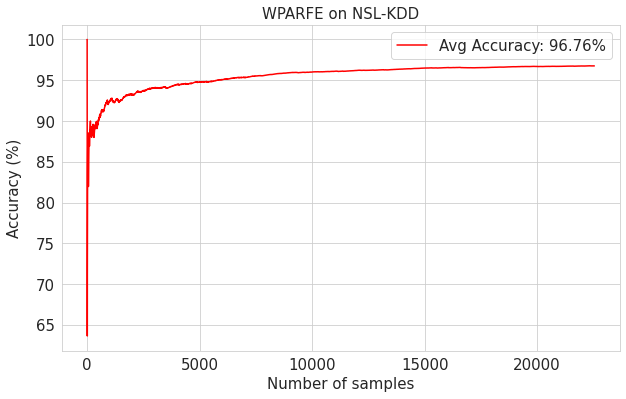

In [ ]:
accuracy_plot(data_indices, real_time_acc,"WPARFE", 'NSL-KDD')

In [ ]:
import pickle
def save_model(model,model_name):
  '''
  Function to save our trained classical machine learning models
  :param model: The trained machine learning model
  :param filename: The filepath where we want to save the model
  '''
  pkl_filename = "{}.pkl".format(model_name)
  with open(pkl_filename, 'wb') as file:
      pickle.dump(model, file)


def open_dumped_cross_validation(filename):
    file = open(filename, "rb")
    output = pickle.load(file)
    return output


In [ ]:
save_model(model_adwin, "model_adwin_v1_97")
save_model(model_ddm, "model_ddm_v1_97")
save_model(model_kswin, "model_kswin_v1_97")

--------------- MODEL ACCURACY ---------------


Accuracy: 0.9608765081618169
--------------- CONFUSION MATRIX ---------------




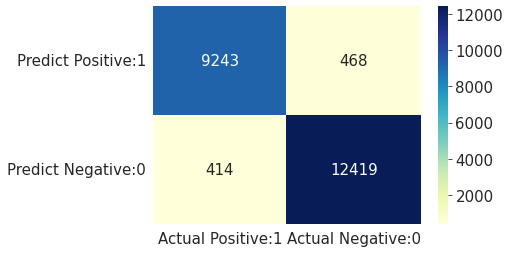


True Positives(TP) =  9243

True Negatives(TN) =  12419

False Positives(FP) (Type I Error) =  468

False Negatives(FN) (Type II Error) =  414


--------------- CLASSIFICATION REPORT ---------------


              precision    recall  f1-score   support

         0.0       0.96      0.95      0.95      9711
         1.0       0.96      0.97      0.97     12833

    accuracy                           0.96     22544
   macro avg       0.96      0.96      0.96     22544
weighted avg       0.96      0.96      0.96     22544



--------------- PERFORMANCE METRICS ---------------


Classification accuracy : 0.9609
Classification error : 0.0391
Precision : 0.9518
Recall or Sensitivity : 0.9571
False Positive Rate (Type I Error): 0.0363
False Negative Rate (Type II Error): 0.0429
Specificity : 0.9637
ROCAUC: 95.98%


----------------- Accuracy Over Time Graph -----------------




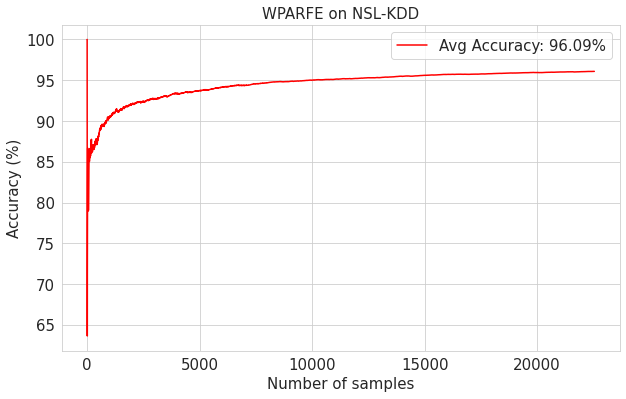

In [ ]:

classification_custom_report_ensemble(y_test,y_pred_WPARFE,x_test, data_indices, real_time_acc)